# EV Charging Data and Access
### By: Aida Rahim

Explore charging behavior as well as access to home-based charging facilities. 

Charging happens primarily at home and at the workplace, with secondary charging out in the public domain. We look at the different representative profiles of time series charging data from public domain stations (in Palo Alto), a workplace (JPL in California), and some homes (in the MidWest).

1. Publicly accessible charging stations: [City of Palo Alto](https://data.cityofpaloalto.org/datasets/176684/electric-vehicle-charging-station-usage-fy-2011-fy-2017/)
    
2. Workplace charging data: ACN = [Adaptive Charging Network](https://ev.caltech.edu/info)
    
3. Charging at home: [NREL](https://data.nrel.gov/submissions/69)

For equitable access to charging facilities, it is important that homes have charging facilities. At single family homes, charging can occur directly from an outlet. But for those living in apartments, condos, townhouses or other street parking-only locations, these can be considered 'garage orphans'. We look at [housing permits](https://data-seattlecitygis.opendata.arcgis.com/datasets/b15bb712fa0a4f4c9862a78e6d7da513_0?geometry=-122.945%2C47.534%2C-121.715%2C47.696) in Seattle since 2010 for trends.


1. [Charging data from public stations](#public_charging)
    1. [Charge duration](#charge_duration)
    2. [Total charging duration by day](#total_by_day)
    3. [Month-long daily totals](#yearlong_daily)
    4. [Modeling public charging](#model_public)
        1. [ARIMA](#ARIMA)
        2. [SARIMAX](#SARIMAX)
        3. [Prophet](#prophet)
    5. [Aggregation](#aggregation)
2. [Workplace charging data](#workplace_charging)
    1. [Workplace aggregation](#workplace_aggregation)
    2. [SARIMAX models](#workplace_sarimax)
        1. [Hourly data](#workplace_hourly)
        2. [Daily data](#workplace_daily)
        3. [Seasonal differencing](#seasonal_differencing)
3. [Home charging data](#home_charging)
    1. [K-Means clustering](#kmeans)
4. [Seattle housing permits](#housing_permits)
    1. [Benford's Law?](#benford)
    2. [Single family housing](#single_family)

In [1]:
# import custom functions
from libfunctions import *

# import the basics
import numpy as np
import pandas as pd
import re

# plotting-related imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import matplotlib
# matplotlib.style.use('ggplot')

# mapping-related imports
import folium
import requests
import json

from datetime import datetime, timedelta
import pytz

# Import time series modeling tools (ARIMA, SARIMAX, Prophet)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# import tools for model evaluation
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# clustering
# from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import silhouette_score

# settings to view full dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Importing plotly failed. Interactive plots will not work.


<a id="public_charging"></a>
# 1. Charging data from public stations

In [2]:
paloalto = pd.read_csv('../Data/ElectricVehicleChargingStationUsageFY2011FY2017_2425291616465431082.csv')

# convert to lowercase, snakecase
paloalto.columns = paloalto.columns.str.lower()
paloalto.rename(columns=lambda c: c.replace(' ','_'), inplace=True)

paloalto.shape

(9999, 39)

In [3]:
paloalto.head()

,station_name,mac_address,org_name,start_date,start_time_zone,end_date,end_time_zone,transaction_date_(pacific_time),total_duration_(hh:mm:ss),charging_time_(hh:mm:ss),energy_(kwh),ghg_savings_(kg),gasoline_savings_(gallons),port_type,port_number,plug_type,evse_id,address_1,unnamed:_18,city,state/province,postal_code,country,latitude,longitude,currency,fee,ended_by,plug_in_event_id,driver_postal_code,county,system_s/n,model_number,year,month,day,hour,park_duration,charge_duration
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,29/07/2011 20:17,PDT,29/07/2011 23:20,PDT,29/07/2011 23:20,03:03:32,01:54:03,6.0,3.0,1.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444572","-122,160309",USD,0,Plug Out at Vehicle,3,95124.0,NaN,NaN,NaN,2011,7,29,20,184.00,114.0
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,30/07/2011 00:00,PDT,30/07/2011 00:02,PDT,30/07/2011 00:02,00:02:06,00:01:54,0.0,0.0,0.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444572","-122,160309",USD,0,Customer,4,94301.0,NaN,NaN,NaN,2011,7,30,0,2.00,2.0
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,30/07/2011 08:16,PDT,30/07/2011 12:34,PDT,30/07/2011 12:34,04:17:32,04:17:28,15.0,6.0,2.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444572","-122,160309",USD,0,Plug Out at Vehicle,5,94301.0,NaN,NaN,NaN,2011,7,30,8,258.00,257.0
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,30/07/2011 14:51,PDT,30/07/2011 16:55,PDT,30/07/2011 16:55,02:03:24,02:02:58,7.0,3.0,1.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444572","-122,160309",USD,0,Customer,6,94302.0,NaN,NaN,NaN,2011,7,30,14,123.00,123.0
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,30/07/2011 18:51,PDT,30/07/2011 20:03,PDT,30/07/2011 20:03,01:11:24,00:43:54,2.0,1.0,0.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444572","-122,160309",USD,0,Plug Out at Vehicle,7,94043.0,NaN,NaN,NaN,2011,7,30,18,71.00,44.0


In [4]:
paloalto.columns

Index(['station_name', 'mac_address', 'org_name', 'start_date',
       'start_time_zone', 'end_date', 'end_time_zone',
       'transaction_date_(pacific_time)', 'total_duration_(hh:mm:ss)',
       'charging_time_(hh:mm:ss)', 'energy_(kwh)', 'ghg_savings_(kg)',
       'gasoline_savings_(gallons)', 'port_type', 'port_number', 'plug_type',
       'evse_id', 'address_1', 'unnamed:_18', 'city', 'state/province',
       'postal_code', 'country', 'latitude', 'longitude', 'currency', 'fee',
       'ended_by', 'plug_in_event_id', 'driver_postal_code', 'county',
       'system_s/n', 'model_number', 'year', 'month', 'day', 'hour',
       'park_duration', 'charge_duration'],
      dtype='object')

In [5]:
paloalto['plug_type'].value_counts(dropna=False)

J1772         9204
NEMA 5-20R     795
Name: plug_type, dtype: int64

J1772: level 2 charger. NEMA 5-20R: level 1 charger.

In [6]:
# convert to datetime
# cols_datetime = ['start_date','end_date','transaction_date_(pacific_time)']
paloalto['start_date'] = pd.to_datetime(paloalto['start_date'])
paloalto.rename(columns={'start_date':'date'},inplace=True)

paloalto.tail(2)

,station_name,mac_address,org_name,date,start_time_zone,end_date,end_time_zone,transaction_date_(pacific_time),total_duration_(hh:mm:ss),charging_time_(hh:mm:ss),energy_(kwh),ghg_savings_(kg),gasoline_savings_(gallons),port_type,port_number,plug_type,evse_id,address_1,unnamed:_18,city,state/province,postal_code,country,latitude,longitude,currency,fee,ended_by,plug_in_event_id,driver_postal_code,county,system_s/n,model_number,year,month,day,hour,park_duration,charge_duration
9997,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2013-03-15 12:46:00,PDT,15/03/2013 15:03,PDT,15/03/2013 15:03,02:16:56,02:16:45,7.0,3.0,1.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444489","-122,16037",USD,0,Plug Out at Vehicle,2856,94403.0,NaN,NaN,NaN,2013,3,15,12,137.00,137.0
9998,PALO ALTO CA / BRYANT #1,000D6F0000A20D9E,City of Palo Alto,2013-03-15 13:44:00,PDT,15/03/2013 13:45,PDT,15/03/2013 13:45,00:01:28,00:01:18,0.0,0.0,0.0,Level 2,2,J1772,NaN,Bryant St,NaN,Palo Alto,California,94301,United States,"37,446613","-122,162308",USD,0,Plug Out at Vehicle,2033,94538.0,NaN,NaN,NaN,2013,3,15,13,1.00,1.0


In [7]:
paloalto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   station_name                     9999 non-null   object        
 1   mac_address                      9999 non-null   object        
 2   org_name                         9999 non-null   object        
 3   date                             9999 non-null   datetime64[ns]
 4   start_time_zone                  9999 non-null   object        
 5   end_date                         9999 non-null   object        
 6   end_time_zone                    9999 non-null   object        
 7   transaction_date_(pacific_time)  9999 non-null   object        
 8   total_duration_(hh:mm:ss)        9999 non-null   object        
 9   charging_time_(hh:mm:ss)         9999 non-null   object        
 10  energy_(kwh)                     9999 non-null   float64    

Null values exist in fields that are not important to us.

In [8]:
paloalto['station_name'].value_counts()

PALO ALTO CA / HAMILTON #1    2335
PALO ALTO CA / HAMILTON #2    2149
PALO ALTO CA / BRYANT #2      1992
PALO ALTO CA / BRYANT #1      1885
PALO ALTO CA / HIGH #4        1638
Name: station_name, dtype: int64

Charging station locations:
* Hamilton #1 & #2 - 250 Hamilton Ave: Downtown Palo Alto, on the street
* High #4 - 528 High Street: Parking Garage in downtown
* Bryant #1 & #2 - Bryant Street downtown Palo Alto parking garage

<a id="charge_duration"></a>
## A. Charge duration

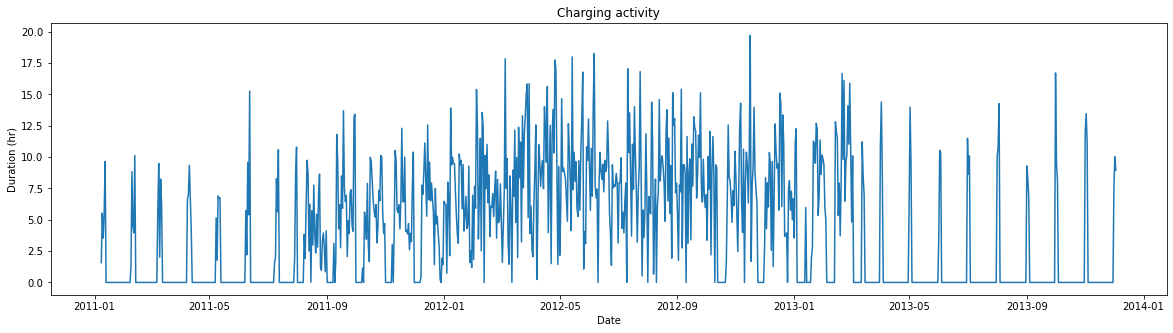

In [9]:
# Location 'PALO ALTO CA / HAMILTON #1', charger #2
specific_stn = paloalto[(paloalto['station_name']=='PALO ALTO CA / HAMILTON #1') & (paloalto['port_number']==2)][['date','charge_duration']]
specific_stn['charge_duration'] = specific_stn['charge_duration']/60 # convert to hours
specific_stn_resample = specific_stn.set_index('date').sort_index()
specific_stn_resample = specific_stn_resample.resample('D').sum()

# plot
plt.figure(figsize=(20,5))
plt.plot(specific_stn_resample)
plt.xlabel('Date')
plt.ylabel('Duration (hr)')
plt.title('Charging activity')
plt.show()

It looks like charging data is consistent mostly throughout 2012. Let's truncate our data to just 2012.

In [10]:
paloalto = paloalto[(paloalto['date']>'2012-1-1') & (paloalto['date']<'2013-1-1')]
paloalto.tail(2)

,station_name,mac_address,org_name,date,start_time_zone,end_date,end_time_zone,transaction_date_(pacific_time),total_duration_(hh:mm:ss),charging_time_(hh:mm:ss),energy_(kwh),ghg_savings_(kg),gasoline_savings_(gallons),port_type,port_number,plug_type,evse_id,address_1,unnamed:_18,city,state/province,postal_code,country,latitude,longitude,currency,fee,ended_by,plug_in_event_id,driver_postal_code,county,system_s/n,model_number,year,month,day,hour,park_duration,charge_duration
8025,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,2012-12-31 17:43:00,PST,31/12/2012 17:56,PST,31/12/2012 17:56,00:12:34,00:11:59,1.0,0.0,0.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444489","-122,16037",NaN,0,Customer,2324,94306.0,NaN,NaN,NaN,2012,12,31,17,13.00,12.0
8026,PALO ALTO CA / HAMILTON #2,000D:6F00:009E:D39E,City of Palo Alto,2012-12-31 18:04:00,PST,31/12/2012 19:53,PST,31/12/2012 19:53,01:48:35,01:48:20,5.0,2.0,1.0,Level 2,2,J1772,NaN,250 Hamilton Ave,NaN,Palo Alto,California,94301,United States,"37,444607","-122,160263",USD,0,Customer,2029,94024.0,NaN,NaN,NaN,2012,12,31,18,109.00,108.0


<a id="total_by_day"></a>
## B. Total charging duration for each location, by day
For just 1 plug (plug #2).

In [11]:
paloalto = paloalto.sort_values(by='date')

# create list of locations
locations = list(paloalto['station_name'].unique())

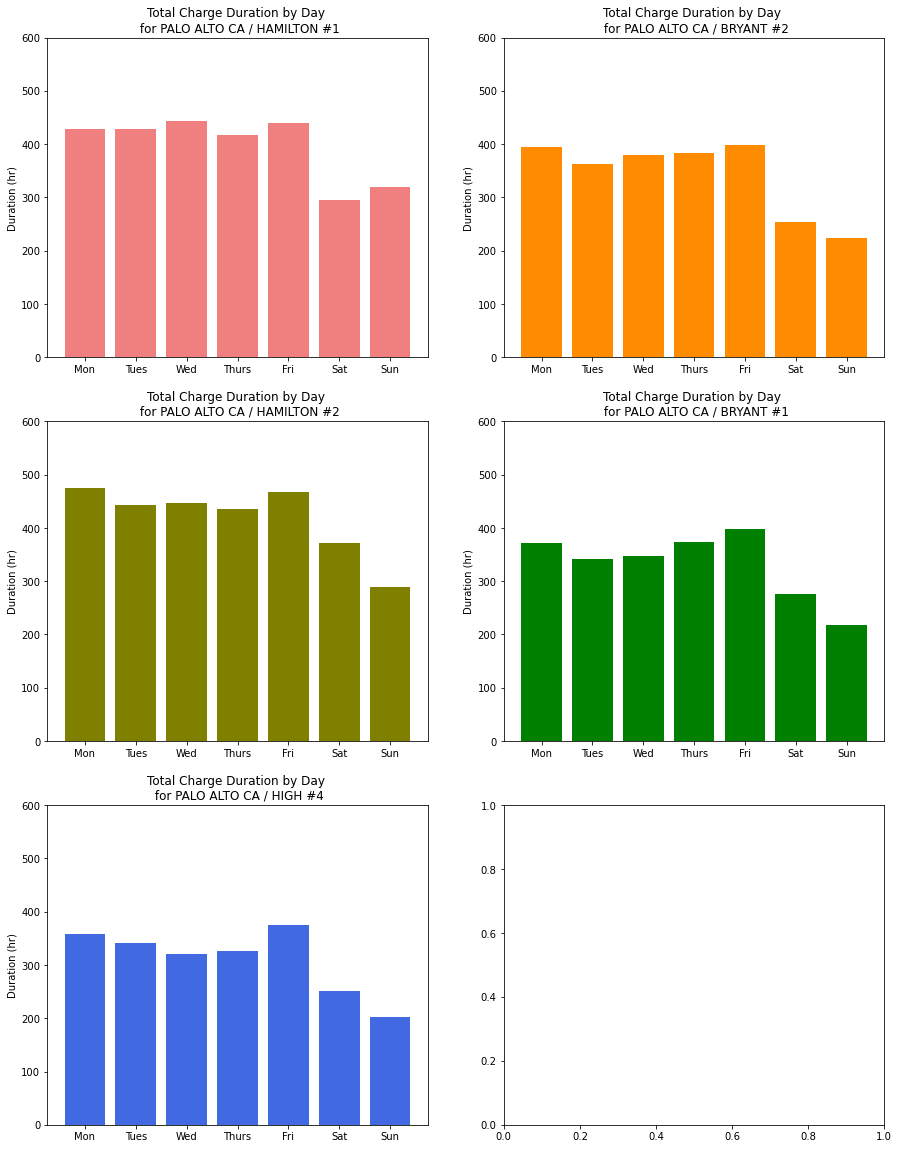

In [12]:
x = np.arange(7)
my_xticks = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
colors = ['lightcoral','darkorange','olive','green','royalblue','lightblue']

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,20))

for ind, location in enumerate(locations):
    
    # extract data for specific station
    location = locations[ind]
    specific_stn = paloalto[(paloalto['station_name']==location) & (paloalto['port_number']==2)][['date','charge_duration']]
    specific_stn['charge_duration'] = specific_stn['charge_duration']/60 # convert to hours
    
    # create 'day' column
    specific_stn['day'] = specific_stn['date'].map(lambda x: x.weekday())
    
    # total charge duration by day
    specific_stn_day = specific_stn.groupby('day').sum()

    # custom x-ticks: https://stackoverflow.com/questions/3100985/plot-with-custom-text-for-x-axis-points
    # Plot!
    plt.subplot(3,2,ind+1)
    plt.bar(specific_stn_day.index,specific_stn_day['charge_duration'],color=colors[ind])
    plt.xticks(x, my_xticks)
    plt.ylim([0, 600])
    plt.ylabel('Duration (hr)')
    plt.title(f'Total Charge Duration by Day \n for {location}')

Weekend (Sat & Sun) use of these charging stations is less than weekday use.

<a id="yearlong_daily"></a>
## C. Daily total charge duration for each location, over a month

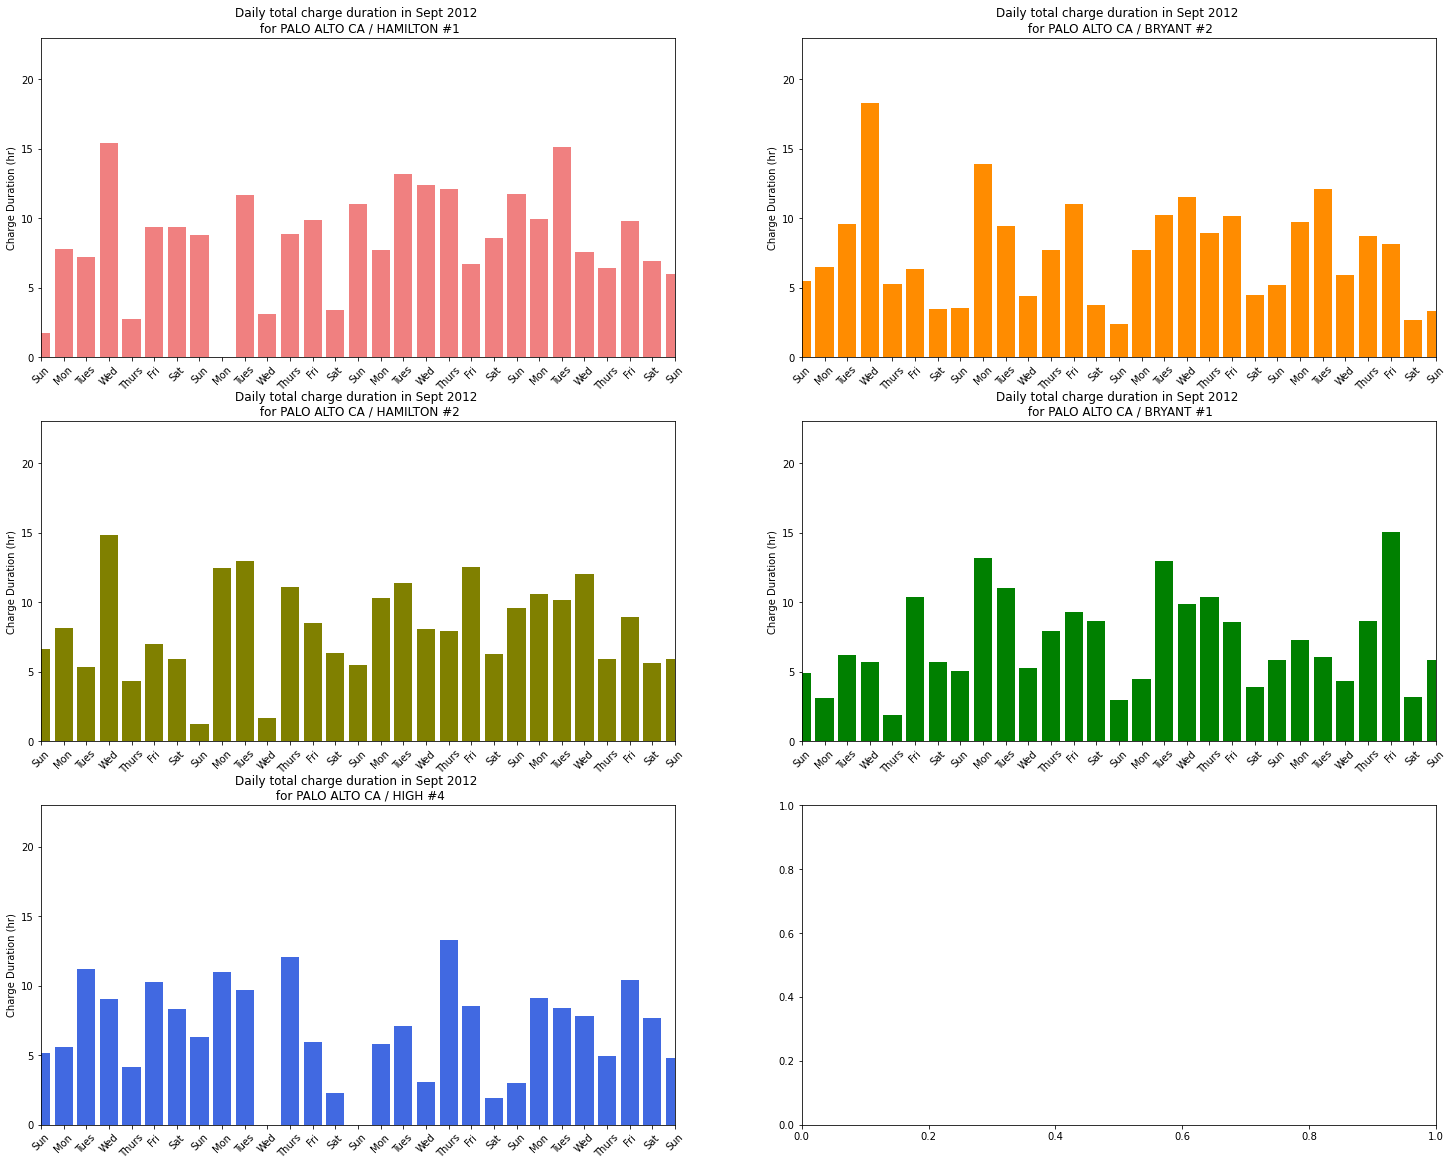

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25,20))
day_dict = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}

for ind, location in enumerate(locations):
    
    # extract data for specific station
    location = locations[ind]
    specific_stn = paloalto[(paloalto['station_name']==location) & (paloalto['port_number']==2)][['date','charge_duration']]
    specific_stn['charge_duration'] = specific_stn['charge_duration']/60 # convert to hours
    
    # Resample: charge duration per business day
    specific_stn_resample = specific_stn.set_index('date').sort_index()
    specific_stn_resample = specific_stn_resample.resample('D').sum()
    specific_stn_resample['day'] = specific_stn_resample.index.map((lambda x: x.weekday()))
    specific_stn_resample['day'] = specific_stn_resample['day'].map(day_dict)
    
    # Plot!
    plt.subplot(3,2,ind+1)
    plt.bar(x = specific_stn_resample.index, height = specific_stn_resample['charge_duration'], color=colors[ind])
    plt.xlabel('')
    plt.ylabel('Charge Duration (hr)')
    plt.title(f'Daily total charge duration in Sept 2012 \n for {location}')
    x = specific_stn_resample.index
    plt.xticks(x, specific_stn_resample['day'], rotation=45)
    plt.xlim([datetime(2012, 9, 2), datetime(2012, 9, 30)])
    plt.ylim(0,23)

The activity level varies by day at each station.

<a id="model_public"></a>
## D. Modeling charging demand at public spaces

In [14]:
specific_stn_resample.drop(columns='day',inplace=True)

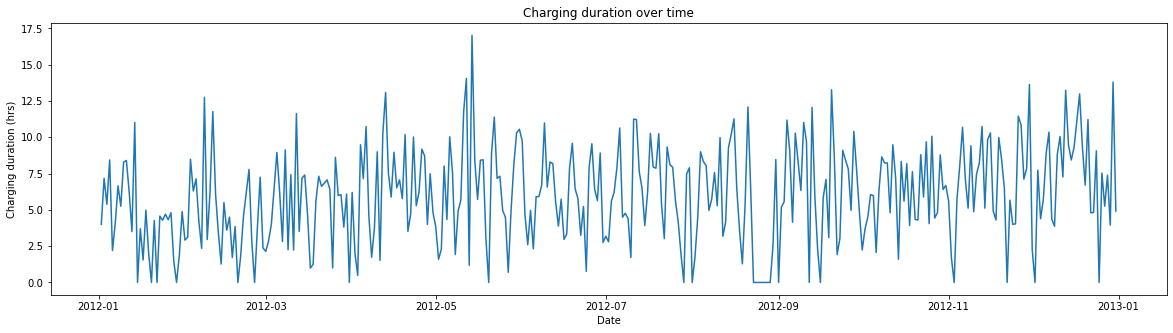

In [15]:
# High #4 from above
plt.figure(figsize=([20,5]))
plt.plot(specific_stn_resample)
plt.xlabel('Date')
plt.ylabel('Charging duration (hrs)')
plt.title('Charging duration over time')
plt.show()

There seems to have been no data for an extended time in Aug 2012. And overall, there does not seem like there is any pattern to this. Is it even possible to model? Let's explore.

In [16]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(specific_stn_resample))

Test Statistic   -5.311927
p-value           0.000005
dtype: float64

H_0: not stationary, H_A: stationary

Non-differenced data has a very small p-value (< 0.005), so we reject the null hypothesis i.e. our data is stationary. For an ARIMA model, we set d = 0.

In [17]:
# Create train-test split.
# 0.9 for train, 0.1 for test
y_train, y_test = train_test_split(specific_stn_resample['charge_duration'], test_size=0.1, shuffle=False) 

<a id="ARIMA"></a>
### a. ARIMA

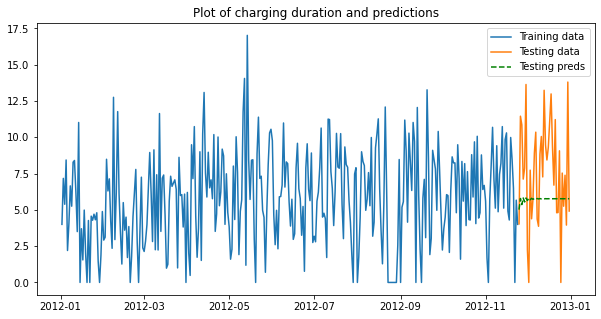

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        charge_duration   No. Observations:                  328
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -841.926
Date:                Sun, 18 Apr 2021   AIC                           1695.851
Time:                        11:05:52   BIC                           1718.609
Sample:                    01-02-2012   HQIC                          1704.931
                         - 11-24-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7652      0.251     22.927      0.000       5.272       6.258
ar.L1         -0.1048      0.387     -0.271      0.787      -0.864       0.654
ar.L2          0.5348      0.205      2.609      0.009       0.133       0.937
ma.L1          0.2750      0.389      0.706      0.480      -0.488       1.038
ma.L2         -0.4683      0.211     -2.221      0.026      -0.882      -0.055
sigma2         9.9303      0.861     11.528      0.000       8.242      11.619
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 3.10
Prob(Q):                              0.83   Prob(JB):                         0.21
Heteroskedasticity (H):               1.11   Skew:                             0.20
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# try an ARIMA model with some p, q
arima_model = ARIMA(endog=y_train, order=(2,0,2)).fit()

test_start = y_test.index[0]
test_end = y_test.index[-1]

arima_preds = arima_model.predict(start=test_start, end=test_end)

model_plot(y_train, y_test, arima_preds, title='Plot of charging duration and predictions', vertlim=None)

display(arima_model.summary())

In [19]:
print(f'RMSE for first ARIMA attempt: {np.sqrt(mean_squared_error(y_test, arima_preds))}')

RMSE for first ARIMA attempt: 3.9690543417228783


In [20]:
specific_stn_resample.mean(), specific_stn_resample.std()

(charge_duration    5.958676
 dtype: float64,
 charge_duration    3.298621
 dtype: float64)

Other than being visually awful, the statistics are not great either, with an RMSE on the same order of the mean and standard deviation. Check ACF/PACF.

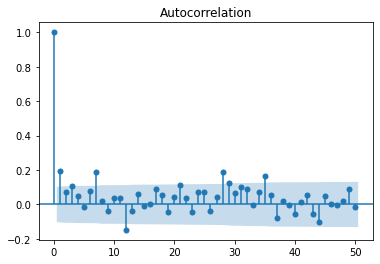

In [21]:
plot_acf(specific_stn_resample, lags=50);

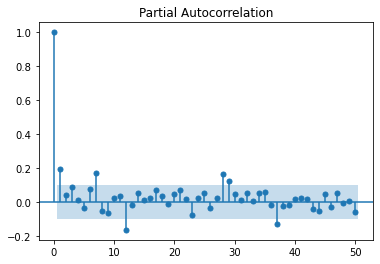

In [22]:
plot_pacf(specific_stn_resample, lags=50);

Looks like there is a weekly component to this data. Perhaps try SARIMA instead.

<a id="SARIMAX"></a>
## b. SARIMAX

In [23]:
# Instantiate a SARIMAX model.
sarima_model = SARIMAX(endog=y_train, order=(2,0,2), seasonal_order=(2,0,2,7)).fit()
# Generate predictions based on test set.
sarima_preds = sarima_model.predict(start=y_test.index[0], end=y_test.index[-1])

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


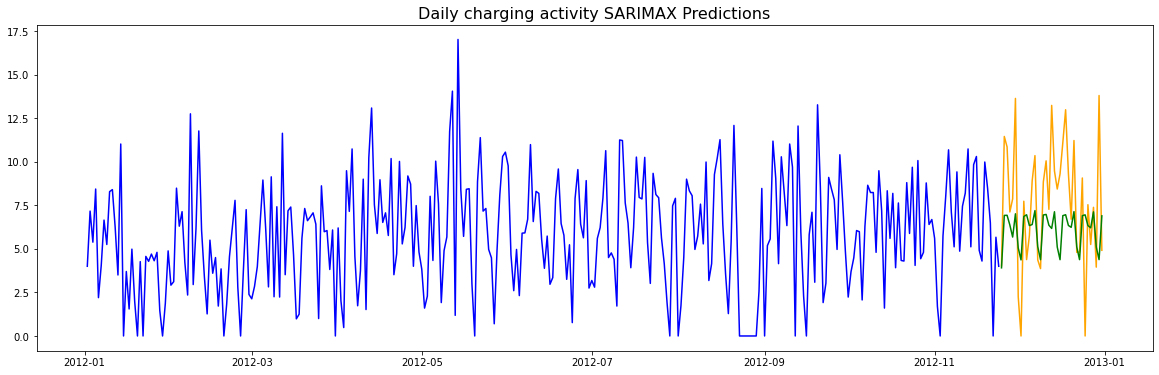

In [24]:
# Plot data.
plt.figure(figsize=(20,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')
# Plot predicted test values.
plt.plot(y_test.index, sarima_preds, color = 'green')
plt.title(label = 'Daily charging activity SARIMAX Predictions', fontsize=16)
plt.show();

In [25]:
print(f'RMSE for first SARIMAX attempt: {np.sqrt(mean_squared_error(y_test, sarima_preds))}')

RMSE for first SARIMAX attempt: 3.5666247035523075


Still not great. The predictions do show weekly pattern, but it does not match the data. Let's try Prophet.

<a id="prophet"></a>
### c. Prophet

In [26]:
# setup for Prophet
df_prophet = specific_stn_resample
df_prophet = df_prophet.reset_index()
df_prophet.columns=['ds','y']
df_prophet.head()

,ds,y
0,2012-01-02,4.000000
1,2012-01-03,7.166667
2,2012-01-04,5.383333
3,2012-01-05,8.433333
4,2012-01-06,2.200000


In [27]:
# Create train-test split.
# 0.9 for train, 0.1 for test
y_train_p = df_prophet[:320]
y_test_p = df_prophet[320:]

In [28]:
# instantiate, fit, predict
m = Prophet()
m.fit(y_train_p)

future = y_test_p[['ds']]
forecast = m.predict(future)

forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
40,2012-12-27,7.189761,3.374336,10.857782
41,2012-12-28,7.934138,4.438164,11.926150
42,2012-12-29,5.890086,2.249953,9.735889
43,2012-12-30,4.663898,0.717844,8.439575
44,2012-12-31,7.475190,3.508493,11.369008


<ipython-input-29-cab4873a9a65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_p['yhat'] = list(forecast['yhat'])


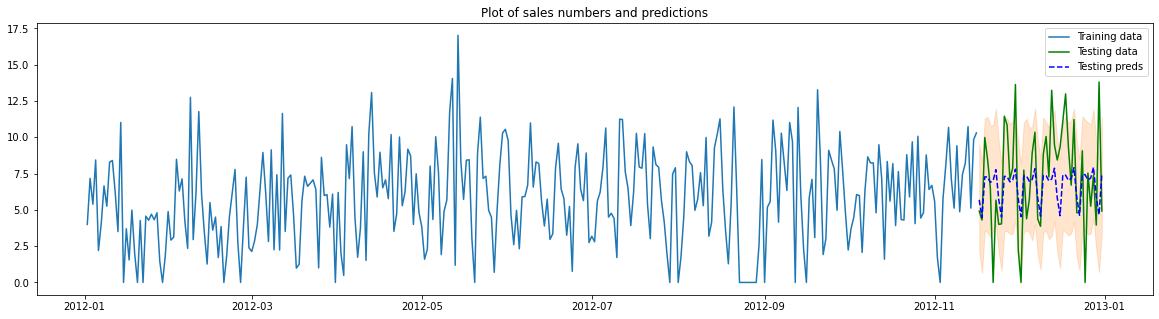

In [29]:
y_test_p['yhat'] = list(forecast['yhat'])

# Plot results
plt.figure(figsize=(20,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train_p['ds'], y_train_p['y'], label='Training data')
plt.plot(y_test_p['ds'], y_test_p['y'], label='Testing data',color='green')
plt.plot(y_test_p['ds'], y_test_p['yhat'], '--', label='Testing preds',color='blue')
plt.fill_between(y_test_p['ds'], forecast['yhat_lower'], forecast['yhat_upper'],color='C1',alpha=0.2)
plt.legend()
plt.show()

In [30]:
np.sqrt(mean_squared_error(y_test_p['y'],y_test_p['yhat']))

3.2761725409332003

Still not great. Let's move away from trying to build a model here.

<a id="aggregation"></a>
## E. Aggregation: When during the day does charging happen more often?
For all locations, resample hourly, separate weekdays from weekends, take mean across all all days in 2012, for each hour.

In [31]:
# create empty df
weekday_hourly = pd.DataFrame(index=range(24))
weekend_hourly = pd.DataFrame(index=range(24))

for ind, location in enumerate(locations):
    location = locations[ind]
    specific_stn = paloalto[(paloalto['station_name']==location) & (paloalto['port_number']==2)][['date','charge_duration']].copy()
    specific_stn['charge_duration'] = specific_stn['charge_duration']/60 # convert to hours
    
    # Resample: charge duration per hour
    specific_stn_resample = specific_stn.set_index('date').sort_index()
    specific_stn_resample = specific_stn_resample.resample('H').sum()
    specific_stn_resample['hour'] = specific_stn_resample.index.hour
    specific_stn_resample['weekday'] = specific_stn_resample.index.weekday
    
    weekday = specific_stn_resample[specific_stn_resample['weekday']<5]
    weekend = specific_stn_resample[specific_stn_resample['weekday']>=5]

    weekday_hourly[location] = weekday.groupby('hour')['charge_duration'].mean()
    weekend_hourly[location] = weekend.groupby('hour')['charge_duration'].mean()

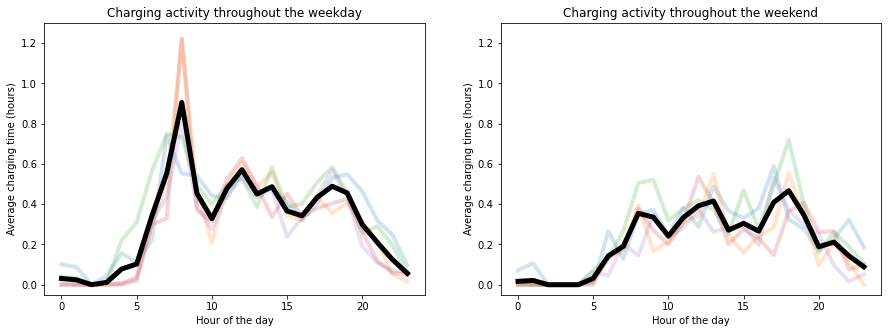

In [32]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(2):
    if i==0: # weekday
        for ind, location in enumerate(locations):
            ax[i].plot(weekday_hourly[location], label=location, alpha=0.2, linewidth=4)
        title = 'Charging activity throughout the weekday'
        ax[i].plot(weekday_hourly.mean(axis=1), c='black', label = 'average', ms=10, linewidth=5)
    else: # weekend
        for ind, location in enumerate(locations):
            ax[i].plot(weekend_hourly[location], label=location, alpha=0.2, linewidth=4)
        title = 'Charging activity throughout the weekend'
        ax[i].plot(weekend_hourly.mean(axis=1), c='black', label = 'average', ms=10, linewidth=5)
        
    ax[i].set_xlabel('Hour of the day')
    ax[i].set_ylabel('Average charging time (hours)')
    ax[i].set_title(title)
    ax[i].set_ylim([-0.05, 1.3])
# ax[i].legend()
plt.show()

Weekday: Charging activity peaks at 8am (people coming into work), noon (lunchtime crowd), and 6pm (dinner crowd), and dies down overnight.

Weekend: Overall charging activity is lower. Charging activity bump at 8am is not as large relative to lunchtime and dinner.

<a id="workplace_charging"></a>
# 2. Workplace charging data

In [33]:
with open('../Data/acndata_sessions_JPL2019.json') as f:
  data = json.load(f)

# with open('../Data/acndata_sessions_JPL2020.json') as f:
#   data = json.load(f)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}


In [35]:
data.keys()

dict_keys(['_meta', '_items'])

In [36]:
# json meta data
data['_meta']

{'end': 'Wed, 01 Jan 2020 04:34:00 GMT',
 'min_kWh': 0,
 'site': 'jpl',
 'start': 'Wed, 02 Jan 2019 04:33:00 GMT'}

In [37]:
# json data sample
data['_items'][0]

{'_id': '5c367245f9af8b4639a8f360',
 'clusterID': '0001',
 'connectionTime': 'Wed, 02 Jan 2019 13:39:11 GMT',
 'disconnectTime': 'Thu, 03 Jan 2019 01:19:57 GMT',
 'doneChargingTime': 'Wed, 02 Jan 2019 15:37:12 GMT',
 'kWhDelivered': 5.871,
 'sessionID': '1_1_191_789_2019-01-02 13:39:11.359003',
 'siteID': '0001',
 'spaceID': 'AG-4F52',
 'stationID': '1-1-191-789',
 'timezone': 'America/Los_Angeles',
 'userID': '000000483',
 'userInputs': [{'WhPerMile': 350,
   'kWhRequested': 10.15,
   'milesRequested': 29,
   'minutesAvailable': 435,
   'modifiedAt': 'Wed, 02 Jan 2019 13:39:29 GMT',
   'paymentRequired': True,
   'requestedDeparture': 'Wed, 02 Jan 2019 20:54:11 GMT',
   'userID': 483}]}

In [38]:
# extract data from json format
entries = [] # initialize empty list

for i in range(len(data['_items'])):
    # create list of the first 12 items (excludes the last item)
    first = list(data['_items'][i].values())[:-1]
    
    # if last item is null, extend list with None's
    # else extend list with values in the last item
    if list(data['_items'][i].values())[-1]==None:
        userinput = [None]*8
        first.extend(userinput)
        entries.append(first)
    else:
        userinput = list(list(data['_items'][i].values())[-1][0].values())
        first.extend(userinput)
        entries.append(first)

In [39]:
# create list of dataframe columns from json file
# convert from camelcase to snakecase: https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case

cols = list(data['_items'][0].keys())[:-1]
cols.extend(list(list(data['_items'][0].values())[-1][0].keys()))

pattern = re.compile(r'(?<!^)(?=[A-Z])')
cols = [pattern.sub('_', name).lower() for name in cols]

In [40]:
# convert list to dataframe
acn = pd.DataFrame(entries)
acn.columns = cols
acn.head(3)

,_id,cluster_i_d,connection_time,disconnect_time,done_charging_time,k_wh_delivered,session_i_d,site_i_d,space_i_d,station_i_d,timezone,user_i_d,wh_per_mile,k_wh_requested,miles_requested,minutes_available,modified_at,payment_required,requested_departure,user_i_d
0,5c367245f9af8b4639a8f360,0001,"Wed, 02 Jan 2019 13:39:11 GMT","Thu, 03 Jan 2019 01:19:57 GMT","Wed, 02 Jan 2019 15:37:12 GMT",5.871,1_1_191_789_2019-01-02 13:39:11.359003,0001,AG-4F52,1-1-191-789,America/Los_Angeles,000000483,350.0,10.15,29.0,435.0,"Wed, 02 Jan 2019 13:39:29 GMT",True,"Wed, 02 Jan 2019 20:54:11 GMT",483.0
1,5c367245f9af8b4639a8f361,0001,"Wed, 02 Jan 2019 13:44:27 GMT","Wed, 02 Jan 2019 22:37:33 GMT","Wed, 02 Jan 2019 19:18:16 GMT",12.094,1_1_178_823_2019-01-02 13:44:26.828039,0001,AG-1F08,1-1-178-823,America/Los_Angeles,000000406,500.0,20.00,40.0,592.0,"Wed, 02 Jan 2019 14:01:23 GMT",True,"Wed, 02 Jan 2019 23:36:27 GMT",406.0
2,5c367245f9af8b4639a8f362,0001,"Wed, 02 Jan 2019 13:47:38 GMT","Wed, 02 Jan 2019 19:01:31 GMT","Wed, 02 Jan 2019 15:06:07 GMT",2.425,1_1_193_829_2019-01-02 13:47:38.465648,0001,AG-1F03,1-1-193-829,America/Los_Angeles,000001117,400.0,4.00,10.0,241.0,"Wed, 02 Jan 2019 13:47:44 GMT",True,"Wed, 02 Jan 2019 17:48:38 GMT",1117.0


In [41]:
# Number of unique plugins for this 1 cluster
num_plugs = len(acn['station_i_d'].unique())
num_plugs

52

In [42]:
# convert all time-related columns to datetime
time_col = ['connection_time', 'disconnect_time', 'done_charging_time', 'modified_at', 'requested_departure']

for val in time_col:
    acn[val] = pd.to_datetime(acn[val])
    

In [43]:
# calculate plugin_duration and charging_duration

acn['plugin_duration'] = acn['disconnect_time'] - acn['connection_time']
acn['charging_duration'] = acn['done_charging_time'] - acn['connection_time']
acn.sort_values('connection_time').head(3)

,_id,cluster_i_d,connection_time,disconnect_time,done_charging_time,k_wh_delivered,session_i_d,site_i_d,space_i_d,station_i_d,timezone,user_i_d,wh_per_mile,k_wh_requested,miles_requested,minutes_available,modified_at,payment_required,requested_departure,user_i_d,plugin_duration,charging_duration
0,5c367245f9af8b4639a8f360,0001,2019-01-02 13:39:11+00:00,2019-01-03 01:19:57+00:00,2019-01-02 15:37:12+00:00,5.871,1_1_191_789_2019-01-02 13:39:11.359003,0001,AG-4F52,1-1-191-789,America/Los_Angeles,000000483,350.0,10.15,29.0,435.0,2019-01-02 13:39:29+00:00,True,2019-01-02 20:54:11+00:00,483.0,0 days 11:40:46,0 days 01:58:01
1,5c367245f9af8b4639a8f361,0001,2019-01-02 13:44:27+00:00,2019-01-02 22:37:33+00:00,2019-01-02 19:18:16+00:00,12.094,1_1_178_823_2019-01-02 13:44:26.828039,0001,AG-1F08,1-1-178-823,America/Los_Angeles,000000406,500.0,20.00,40.0,592.0,2019-01-02 14:01:23+00:00,True,2019-01-02 23:36:27+00:00,406.0,0 days 08:53:06,0 days 05:33:49
2,5c367245f9af8b4639a8f362,0001,2019-01-02 13:47:38+00:00,2019-01-02 19:01:31+00:00,2019-01-02 15:06:07+00:00,2.425,1_1_193_829_2019-01-02 13:47:38.465648,0001,AG-1F03,1-1-193-829,America/Los_Angeles,000001117,400.0,4.00,10.0,241.0,2019-01-02 13:47:44+00:00,True,2019-01-02 17:48:38+00:00,1117.0,0 days 05:13:53,0 days 01:18:29


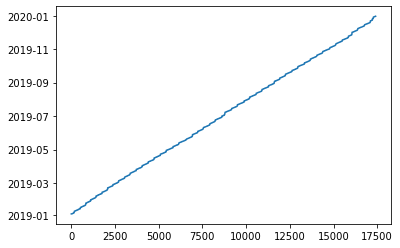

In [44]:
# check connection_time continuity
plt.plot(acn['connection_time'])
plt.show()

In [45]:
plugin_duration = acn[['connection_time','plugin_duration']]

# set index to date column
plugin_duration = plugin_duration.set_index('connection_time').sort_index()

# convert from timedelta to hours: https://stackoverflow.com/questions/31283001/get-total-number-of-hours-from-a-pandas-timedelta
plugin_duration['plugin_duration'] = plugin_duration['plugin_duration']/np.timedelta64(1, 'h')

# resample by daily duration
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation

plugin_duration_hourly = plugin_duration.resample('H').sum()/num_plugs

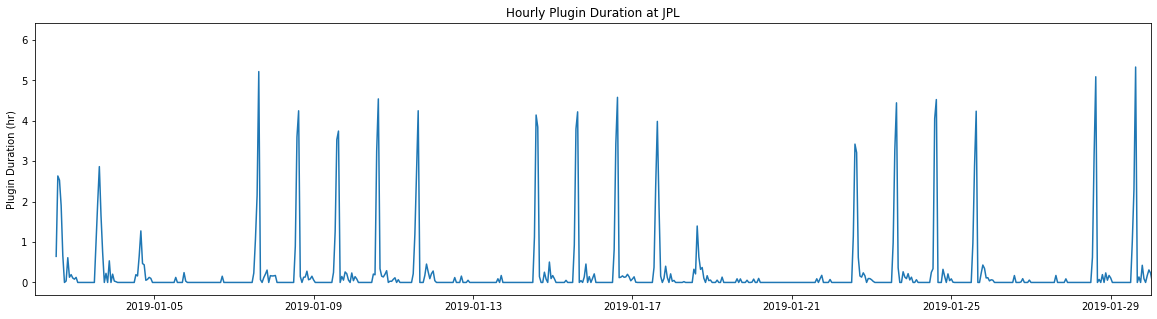

In [46]:
# hourly plugin duration for a month
plt.figure(figsize=(20,5))
plt.plot(plugin_duration_hourly.index,plugin_duration_hourly)
plt.xlim([datetime(2019, 1, 2), datetime(2019, 1, 30)])
plt.ylabel('Plugin Duration (hr)')
plt.title('Hourly Plugin Duration at JPL')
plt.show()

Weekday vs weekend connectivity difference is very pronounced from the plot above. Look at aggregation over time.

<a id="workplace_aggregation"></a>
## A. Workplace data aggregation

Groupby weekday vs weekend, and plot trends.

In [47]:
# create hour and weekday columns
plugin_duration_hourly['hour'] = plugin_duration_hourly.index.hour
plugin_duration_hourly['weekday'] = plugin_duration_hourly.index.weekday

acn_weekday = plugin_duration_hourly[plugin_duration_hourly['weekday']<5]
acn_weekend = plugin_duration_hourly[plugin_duration_hourly['weekday']>=5]

acn_weekday = acn_weekday.groupby('hour')['plugin_duration'].mean()
acn_weekend = acn_weekend.groupby('hour')['plugin_duration'].mean()

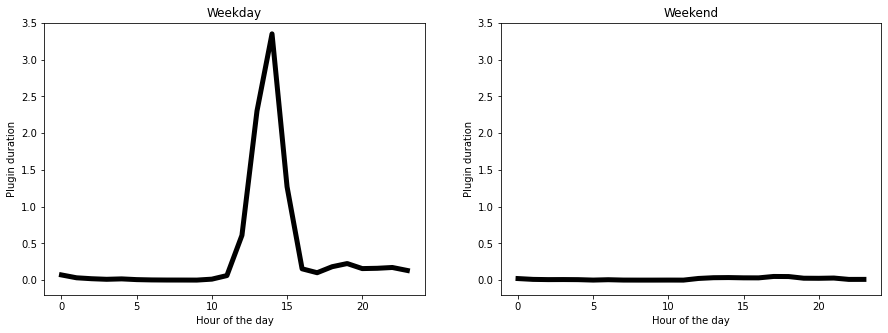

In [48]:
# average hourly plugin duration, weekday vs weekend

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(acn_weekday, linewidth = 5, c='black')
ax[0].set_ylim([-0.2,3.5])
ax[0].set_xlabel('Hour of the day')
ax[0].set_ylabel('Plugin duration')
ax[0].set_title('Weekday')

ax[1].plot(acn_weekend, linewidth = 5, c='black')
ax[1].set_ylim([-0.2,3.5])
ax[1].set_xlabel('Hour of the day')
ax[1].set_ylabel('Plugin duration')
ax[1].set_title('Weekend')

plt.show()

The timezone is Pacific Time, but the timestamps are in GMT, which is 7hrs ahead of Pacific Time. So plugin activity peaks in the morning, around 7am.

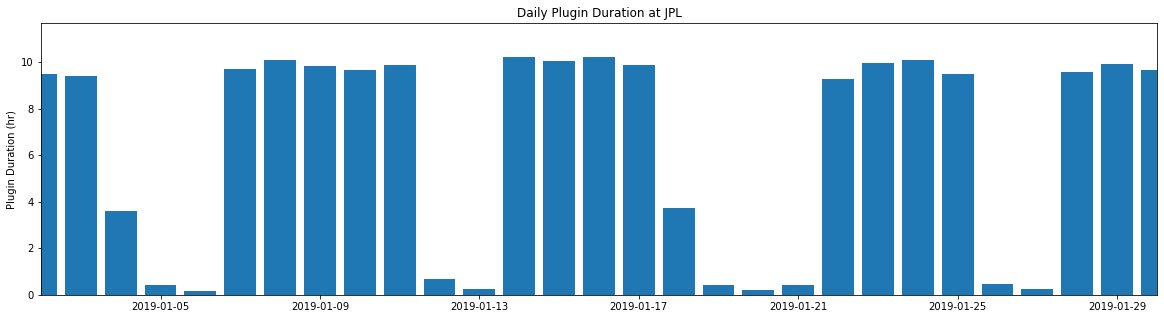

In [49]:
# Let's also look at daily aggregation instead of hourly aggregation
plugin_duration_daily = plugin_duration.resample('D').sum()/num_plugs

# daily plugin duration for a month
plt.figure(figsize=(20,5))
plt.bar(plugin_duration_daily.index,plugin_duration_daily['plugin_duration'])
plt.xlim([datetime(2019, 1, 2), datetime(2019, 1, 30)])
plt.ylabel('Plugin Duration (hr)')
plt.title('Daily Plugin Duration at JPL')
plt.show()

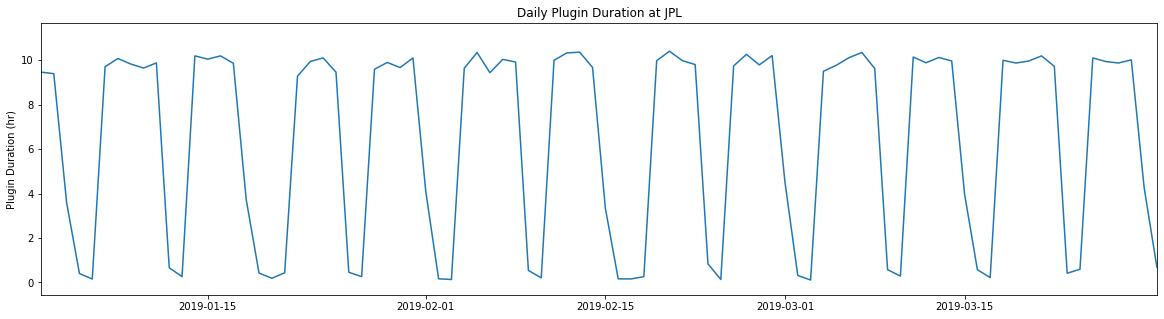

In [50]:
# line plot

plt.figure(figsize=(20,5))
plt.plot(plugin_duration_daily.index,plugin_duration_daily['plugin_duration'])
plt.xlim([datetime(2019, 1, 2), datetime(2019, 3, 30)])
plt.ylabel('Plugin Duration (hr)')
plt.title('Daily Plugin Duration at JPL')
plt.show()

You can see the weekly charging cyclic pattern in this data.

<a id="workplace_sarimax"></a>
## B. SARIMAX models

<a id="workplace_hourly"></a>
### a. Hourly Data
Let's see if SARIMAX will be able to pick out the spikes in hourly data.

In [51]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(plugin_duration_hourly['plugin_duration']))

Test Statistic   -1.120711e+01
p-value           2.170933e-20
dtype: float64

Data is stationary (but there is still daily spikes and cyclic behaviour - odd).

In [52]:
plugin_duration_hourly.head()

,plugin_duration,hour,weekday
connection_time,,,
2019-01-02 13:00:00+00:00,0.645550,13,2
2019-01-02 14:00:00+00:00,2.635182,14,2
2019-01-02 15:00:00+00:00,2.532009,15,2
2019-01-02 16:00:00+00:00,1.902788,16,2
2019-01-02 17:00:00+00:00,0.668259,17,2


In [53]:
# reset plugin_duration_hourly
plugin_duration_hourly = plugin_duration.resample('H').sum()/num_plugs

# Create train-test split.
# 0.9 for train, 0.1 for test
hourly_train, hourly_test = train_test_split(plugin_duration_hourly, test_size=0.1, shuffle=False) 

In [54]:
# Instantiate a SARIMAX model.
shourly = SARIMAX(endog=hourly_train, order=(2,0,2), seasonal_order=(2,0,2,24)).fit()
# Generate predictions based on test set.
shourly_preds = shourly.predict(start=hourly_test.index[0], end=hourly_test.index[-1])

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


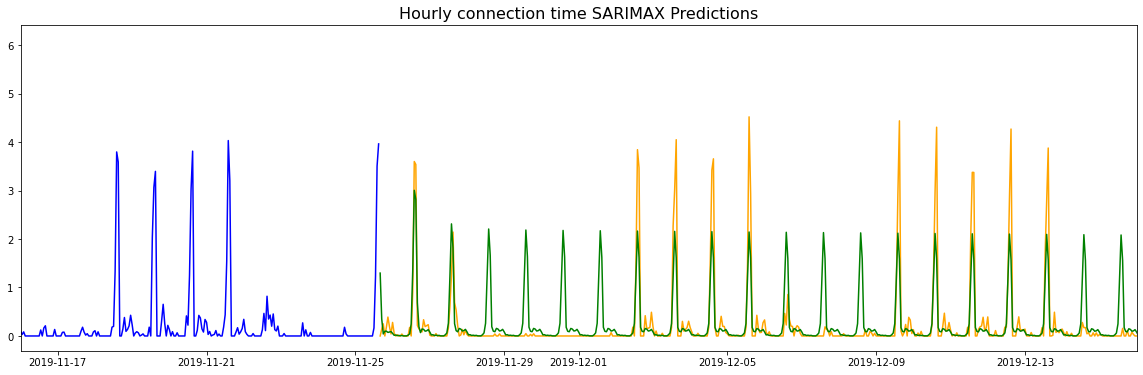

In [55]:
# Plot data.
plt.figure(figsize=(20,6))
# Plot training data.
plt.plot(hourly_train.index, pd.DataFrame(hourly_train), color = 'blue')
# Plot testing data.
plt.plot(hourly_test.index, pd.DataFrame(hourly_test), color = 'orange')
# Plot predicted test values.
plt.plot(hourly_test.index, shourly_preds, color = 'green')
plt.title(label = 'Hourly connection time SARIMAX Predictions', fontsize=16)
plt.xlim([datetime(2019, 11, 16), datetime(2019, 12, 16)])
plt.show();

In [56]:
print(f'RMSE for hourly SARIMAX attempt: {np.sqrt(mean_squared_error(hourly_test, shourly_preds))}')

RMSE for hourly SARIMAX attempt: 0.530026720496069


In [57]:
hourly_test.mean(), hourly_test.std()

(plugin_duration    0.221027
 dtype: float64,
 plugin_duration    0.695978
 dtype: float64)

The predictions are able to pick up the daily spike pattern, but not the fact that weekends are flat. And the predictions level off to basically the same magnitudes. The RMSE is on the same order of magnitude as the standard deviation. 

The data here is too granular to model. Try building a SARIMA model based on the daily aggregated data instead.

<a id="workplace_daily"></a>
### b. Daily Data

In [58]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(plugin_duration_daily))

Test Statistic   -2.951929
p-value           0.039634
dtype: float64

Data is not stationary. Difference once and check again.

In [59]:
plugin_duration_daily['plugin_duration'].diff()

connection_time
2019-01-02 00:00:00+00:00         NaN
2019-01-03 00:00:00+00:00   -0.070187
2019-01-04 00:00:00+00:00   -5.798339
2019-01-05 00:00:00+00:00   -3.193408
2019-01-06 00:00:00+00:00   -0.247687
                               ...   
2019-12-28 00:00:00+00:00   -5.046090
2019-12-29 00:00:00+00:00   -0.136239
2019-12-30 00:00:00+00:00    8.748130
2019-12-31 00:00:00+00:00   -3.820550
2020-01-01 00:00:00+00:00   -4.977217
Freq: D, Name: plugin_duration, Length: 365, dtype: float64

In [60]:
plugin_duration_daily['first_diff'] = plugin_duration_daily['plugin_duration'].diff()

# Run ADF test on original (1-differenced!) data.
interpret_dftest(adfuller(plugin_duration_daily['first_diff'].dropna()))

Test Statistic   -8.737350e+00
p-value           3.074617e-14
dtype: float64

First-differenced data is stationary.

<a id="seasonal_differencing"></a>
### c. Investigate Seasonal Differencing

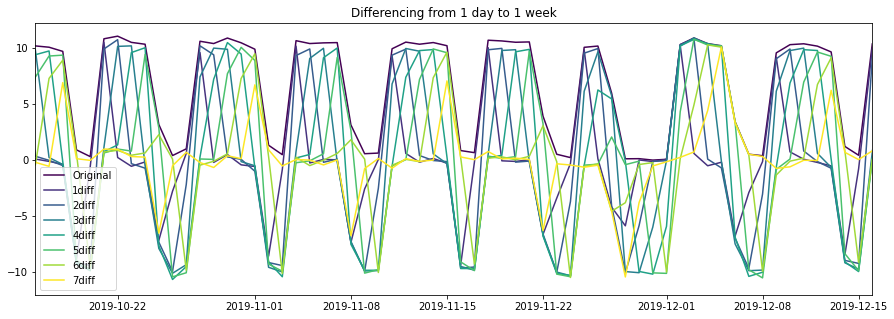

In [61]:
# difference and plot
data = plugin_duration_daily['plugin_duration']
colors = cm.get_cmap('viridis', 8)
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data,c=colors(0),label='Original')
for i in range(1,8):
    label = str(i)+'diff'
    plt.plot(data.diff(i),c=colors(i),label=label)
plt.xlim([datetime(2019, 10, 16), datetime(2019, 12, 16)])
plt.title('Differencing from 1 day to 1 week')
plt.legend()
plt.show()

Pretty but not sure what it means. Use ACF & PACF instead.

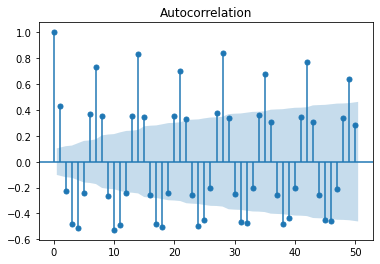

In [62]:
plot_acf(plugin_duration_daily['plugin_duration'], lags=50);

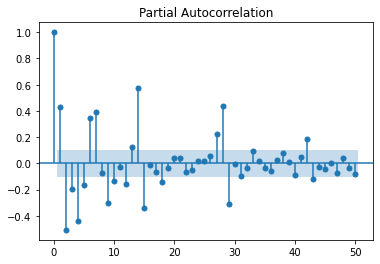

In [63]:
plot_pacf(plugin_duration_daily['plugin_duration'], lags=50);

Strong periodic correlation is visible e.g. at 2 (negative), 7, 14, 28 days.

In [64]:
# Create train-test split.
# 0.9 for train, 0.1 for test
daily_train, daily_test = train_test_split(plugin_duration_daily, test_size=0.1, shuffle=False) 

In [65]:
# manual gridsearch for best parameter combination
# takes awhile. Comment out to jump to the best parameters
# Starting AIC, p, q, and s.
best_aic = 99*(10**16) # start with a crazy huge number
best_p = 0
best_q = 0
best_s = 0

# Use nested for loop to iterate over values of p and q.
for p in [1, 2, 4]:
    for q in [1, 2, 4]:
        for s in [3, 7, 14, 30]:

        
            # Insert try and except statements.
            try:

                # Fitting an SARIMAX(p, 1, q) model.
                print(f'Attempting to fit SARIMAX({p}, 1, {q}, {s})')

                # Instantiate SARIMAX model.
                sarimax = SARIMAX(endog=daily_train['plugin_duration'], order=(2, 1, 2), seasonal_order = (p, 1, q, s)).fit()


                # Print out AIC for SARIMAX(p, 1, q) model.
                print(f'The AIC for SARIMAX({p},1,{q},{s}) is: {sarimax.aic}')

                # Is my current model's AIC better than our best_aic?
                if sarimax.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = sarimax.aic
                    best_p = p
                    best_q = q
                    best_s = s

            except:
                print(f"Error with p={p}, q={q}, s={s}")
                pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the SARIMAX({best_p},1,{best_q},{best_s}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit SARIMAX(1, 1, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for SARIMAX(1,1,1,3) is: 1725.3830935036844
Attempting to fit SARIMAX(1, 1, 1, 7)
The AIC for SARIMAX(1,1,1,7) is: 1230.088782453035
Attempting to fit SARIMAX(1, 1, 1, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(1,1,1,14) is: 1081.896463814218
Attempting to fit SARIMAX(1, 1, 1, 30)
The AIC for SARIMAX(1,1,1,30) is: 1615.0377562964627
Attempting to fit SARIMAX(1, 1, 2, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(1,1,2,3) is: 1727.3524168463664
Attempting to fit SARIMAX(1, 1, 2, 7)
The AIC for SARIMAX(1,1,2,7) is: 1122.5123637635677
Attempting to fit SARIMAX(1, 1, 2, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(1,1,2,14) is: 1080.807907784799
Attempting to fit SARIMAX(1, 1, 2, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(1,1,2,30) is: 1630.4948163988468
Attempting to fit SARIMAX(1, 1, 4, 3)
The AIC for SARIMAX(1,1,4,3) is: 1679.7621939200103
Attempting to fit SARIMAX(1, 1, 4, 7)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(1,1,4,7) is: 1123.8466357600325
Attempting to fit SARIMAX(1, 1, 4, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(1,1,4,14) is: 1081.8565534428976
Attempting to fit SARIMAX(1, 1, 4, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(1,1,4,30) is: 1615.1004259848694
Attempting to fit SARIMAX(2, 1, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,1,3) is: 1784.5237331403644
Attempting to fit SARIMAX(2, 1, 1, 7)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,1,7) is: 1209.3769614015437
Attempting to fit SARIMAX(2, 1, 1, 14)
The AIC for SARIMAX(2,1,1,14) is: 1079.192744988403
Attempting to fit SARIMAX(2, 1, 1, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,1,30) is: 1658.463664530661
Attempting to fit SARIMAX(2, 1, 2, 3)
The AIC for SARIMAX(2,1,2,3) is: 1717.5437802671058
Attempting to fit SARIMAX(2, 1, 2, 7)
The AIC for SARIMAX(2,1,2,7) is: 1124.3235578602698
Attempting to fit SARIMAX(2, 1, 2, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,2,14) is: 1080.7138929671405
Attempting to fit SARIMAX(2, 1, 2, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,2,30) is: 1659.9674402383416
Attempting to fit SARIMAX(2, 1, 4, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,4,3) is: 1535.9073393958079
Attempting to fit SARIMAX(2, 1, 4, 7)
The AIC for SARIMAX(2,1,4,7) is: 1124.5966697514323
Attempting to fit SARIMAX(2, 1, 4, 14)
The AIC for SARIMAX(2,1,4,14) is: 1047.7489969785954
Attempting to fit SARIMAX(2, 1, 4, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(2,1,4,30) is: 1607.1897213435873
Attempting to fit SARIMAX(4, 1, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,1,3) is: 1664.3228274879532
Attempting to fit SARIMAX(4, 1, 1, 7)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,1,7) is: 1159.5014427999427
Attempting to fit SARIMAX(4, 1, 1, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,1,14) is: 1077.5387636713779
Attempting to fit SARIMAX(4, 1, 1, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,1,30) is: 1640.629049991861
Attempting to fit SARIMAX(4, 1, 2, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,2,3) is: 1564.2461076176228
Attempting to fit SARIMAX(4, 1, 2, 7)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,2,7) is: 1124.8817598170008
Attempting to fit SARIMAX(4, 1, 2, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,2,14) is: 1072.1340992898708
Attempting to fit SARIMAX(4, 1, 2, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,2,30) is: 1601.73723290019
Attempting to fit SARIMAX(4, 1, 4, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,4,3) is: 1507.6582194060138
Attempting to fit SARIMAX(4, 1, 4, 7)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,4,7) is: 1110.0190294057052
Attempting to fit SARIMAX(4, 1, 4, 14)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,4,14) is: 1048.0293998968427
Attempting to fit SARIMAX(4, 1, 4, 30)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for SARIMAX(4,1,4,30) is: 1602.514108914993


MODEL FINISHED!
Our model that minimizes AIC on the training data is the SARIMAX(2,1,4,14).
This model has an AIC of 1047.7489969785954.


In [66]:
# Best model has seasonal_order = (2, 1, 4, 14), with best AIC of 1047.75
# AIC measures information lost when reality is simplified with a model
# So rebuild model with these parameters

# Instantiate a SARIMAX model.
sdaily = SARIMAX(endog=daily_train['plugin_duration'], order=(2,1,2), seasonal_order=(2,1,4,14)).fit()
# Generate predictions based on test set.
sdaily_preds = sdaily.predict(start=daily_test.index[0], end=datetime(2020,4,1,8, 15, 12, 0,pytz.UTC))

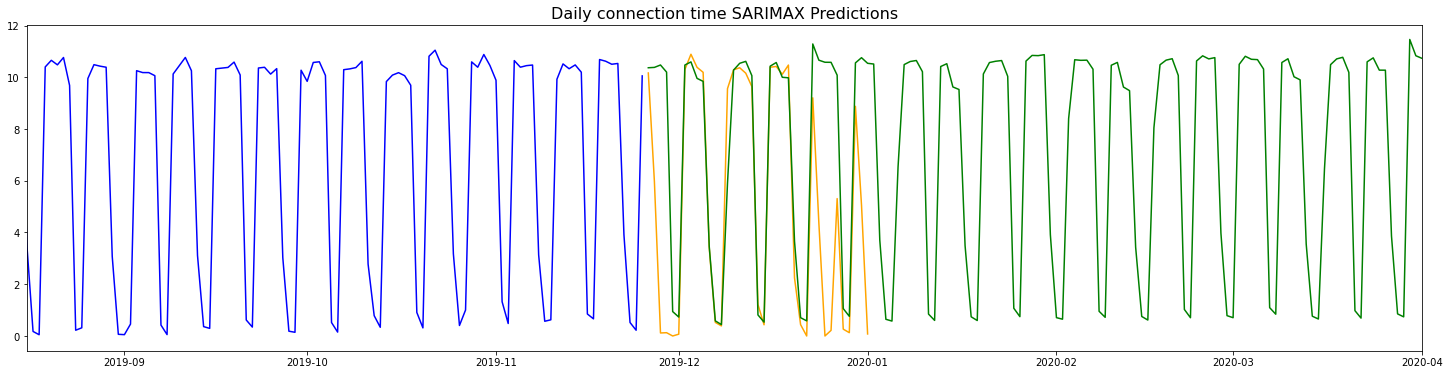

In [67]:
# Plot data.
plt.figure(figsize=(25,6))
# Plot training data.
plt.plot(daily_train.index, daily_train['plugin_duration'], color = 'blue',label='Train')
# Plot testing data.
plt.plot(daily_test.index, daily_test['plugin_duration'], color = 'orange',label='Test')
# Plot predicted test values.
plt.plot(sdaily_preds.index, sdaily_preds, color = 'green',label='Predictions')
plt.title(label = 'Daily connection time SARIMAX Predictions', fontsize=16)
plt.xlim([datetime(2019, 8, 16), datetime(2020,4,1)])
# plt.legend()
plt.show();

Data quality deteriorates at the end of Dec 2019, so we can continue using this model to predict into the future instead of building a new one trained on the entire dataset.

<a id="energy_delivered"></a>
## C. Energy Delivered
While the timing of charging activity is 1 way to check for charging need, and makes sense for planning purposes for publicly accessible stations, energy delivered / energy draw is important for planning power regulation at the grid level.

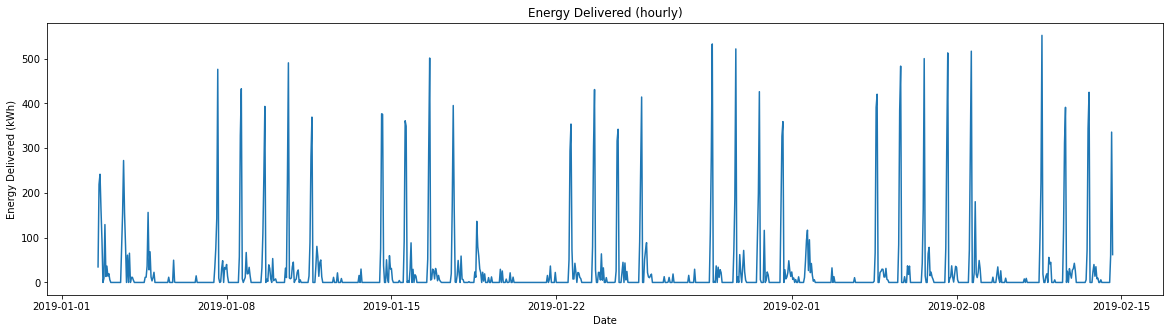

In [68]:
kwh_delivered = acn[['connection_time','k_wh_delivered']]

sub_kwh = kwh_delivered.head(2000)

# set index to date column
sub_kwh = sub_kwh.set_index('connection_time').sort_index()

sub_kwh = sub_kwh.resample('H').sum()
plt.figure(figsize=[20,5])
plt.plot(sub_kwh)
plt.xlabel('Date')
plt.ylabel('Energy Delivered (kWh)')
plt.title('Energy Delivered (hourly)')
plt.show()

#### The Prophet model can also be used for this
We only apply a cursory attempt here, without optimization

In [69]:
dfsize = 10000

sub_kwh = kwh_delivered.head(dfsize)
sub_kwh = sub_kwh.set_index('connection_time').sort_index()

sub_kwh = sub_kwh.resample('D').sum()
sub_kwh.reset_index(inplace=True)

sub_kwh.columns=['ds','y']

sub_kwh['ds'] = pd.to_datetime(sub_kwh['ds'])
sub_kwh['ds'] = sub_kwh['ds'].apply(lambda x: x.replace(tzinfo=None))

# Create train-test split.
# 0.9 for train, 0.1 for test
split_val = round(sub_kwh.shape[0]*0.8)
y_train_p = sub_kwh[:split_val]
y_test_p = sub_kwh[split_val:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
<ipython-input-70-167adc4e96e3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_p['yhat'] = list(forecast['yhat'])


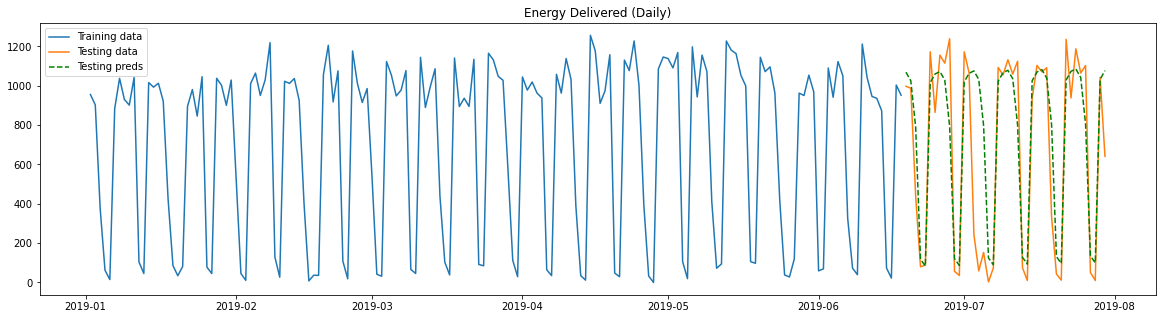

In [70]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True)
# m = Prophet(weekly_seasonality=True)
m.fit(y_train_p)

future = y_test_p[['ds']]
forecast = m.predict(future)

y_test_p['yhat'] = list(forecast['yhat'])

plt.figure(figsize=(20,5))
plt.title('Energy Delivered (Daily)')
plt.plot(y_train_p['ds'], y_train_p['y'], label='Training data')
plt.plot(y_test_p['ds'], y_test_p['y'], label='Testing data')
plt.plot(y_test_p['ds'], y_test_p['yhat'], '--', label='Testing preds',color='green')
plt.legend()
plt.show()

<a id="home_charging"></a>
# 3. Home charging data

In [71]:
home = pd.read_excel('../Data/PEV-Profiles-L1.xlsx', sheet_name='PEV-Profiles-L1.csv') # takes awhile to load

<img src="../images/Matteo.png" alt="Matteo Muratori" style="width: 800px;"/>

Please cite as: "Matteo Muratori, Impact of uncoordinated plug-in electric vehicle charging on residential power demand - supplementary data, 2017 [1]. Based on modeling reported in [2]."

[1] M. Muratori, "Impact of uncoordinated plug-in electric vehicle charging on residential power demand." Forthcoming.

[2] M. Muratori, M. J. Moran, E. Serra, and G. Rizzoni, “Highly-resolved modeling of personal transportation energy consumption in the United States,” Energy, vol. 58, no. 0, pp. 168–177, 2013.

In [72]:
home.head()

,Residential PEV Charging [W],Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264,Unnamed: 265,Unnamed: 266,Unnamed: 267,Unnamed: 268,Unnamed: 269,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275,Unnamed: 276,Unnamed: 277,Unnamed: 278,Unnamed: 279,Unnamed: 280,Unnamed: 281,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285,Unnamed: 286,Unnamed: 287,Unnamed: 288,Unnamed: 289,Unnamed: 290,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,Unnamed: 295,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300,Unnamed: 301,Unnamed: 302,Unnamed: 303,Unnamed: 304,Unnamed: 305,Unnamed: 306,Unnamed: 307,Unnamed: 308,Unnamed: 309,Unnamed: 310,Unnamed: 311,Unnamed: 312,Unnamed: 313,Unnamed: 

In [73]:
home.shape

(52562, 349)

In [74]:
# clean up dataframe
households = list(home.loc[0,:])[1:]
vehicles = list(home.loc[1,:])[1:]

home2 = home.copy()

home2.drop(index=[0,1],inplace=True)

col_names = ['date'] + vehicles
home2.columns = col_names

# column names: snakecase, lowercase
home2.columns = home2.columns.str.lower()
home2.rename(columns=lambda c: c.replace(' ','_'), inplace=True)

In [75]:
new_cols = home2.columns[1:]
home2[new_cols] = home2[new_cols].replace(1920,1)

home2['date'] = pd.to_datetime(home2['date'])
home2 = home2.set_index('date').sort_index()
home2.head(2)

,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,vehicle_6,vehicle_7,vehicle_8,vehicle_9,vehicle_10,vehicle_11,vehicle_12,vehicle_13,vehicle_14,vehicle_15,vehicle_16,vehicle_17,vehicle_18,vehicle_19,vehicle_20,vehicle_21,vehicle_22,vehicle_23,vehicle_24,vehicle_25,vehicle_26,vehicle_27,vehicle_28,vehicle_29,vehicle_30,vehicle_31,vehicle_32,vehicle_33,vehicle_34,vehicle_35,vehicle_36,vehicle_37,vehicle_38,vehicle_39,vehicle_40,vehicle_41,vehicle_42,vehicle_43,vehicle_44,vehicle_45,vehicle_46,vehicle_47,vehicle_48,vehicle_49,vehicle_50,vehicle_51,vehicle_52,vehicle_53,vehicle_54,vehicle_55,vehicle_56,vehicle_57,vehicle_58,vehicle_59,vehicle_60,vehicle_61,vehicle_62,vehicle_63,vehicle_64,vehicle_65,vehicle_66,vehicle_67,vehicle_68,vehicle_69,vehicle_70,vehicle_71,vehicle_72,vehicle_73,vehicle_74,vehicle_75,vehicle_76,vehicle_77,vehicle_78,vehicle_79,vehicle_80,vehicle_81,vehicle_82,vehicle_83,vehicle_84,vehicle_85,vehicle_86,vehicle_87,vehicle_88,vehicle_89,vehicle_90,vehicle_91,vehicle_92,vehicle_93,vehicle_94,vehicle_95,vehicle_96,vehicle_97,vehicle_98,vehicle_99,vehicle_100,vehicle_101,vehicle_102,vehicle_103,vehicle_104,vehicle_105,vehicle_106,vehicle_107,vehicle_108,vehicle_109,vehicle_110,vehicle_111,vehicle_112,vehicle_113,vehicle_114,vehicle_115,vehicle_116,vehicle_117,vehicle_118,vehicle_119,vehicle_120,vehicle_121,vehicle_122,vehicle_123,vehicle_124,vehicle_125,vehicle_126,vehicle_127,vehicle_128,vehicle_129,vehicle_130,vehicle_131,vehicle_132,vehicle_133,vehicle_134,vehicle_135,vehicle_136,vehicle_137,vehicle_138,vehicle_139,vehicle_140,vehicle_141,vehicle_142,vehicle_143,vehicle_144,vehicle_145,vehicle_146,vehicle_147,vehicle_148,vehicle_149,vehicle_150,vehicle_151,vehicle_152,vehicle_153,vehicle_154,vehicle_155,vehicle_156,vehicle_157,vehicle_158,vehicle_159,vehicle_160,vehicle_161,vehicle_162,vehicle_163,vehicle_164,vehicle_165,vehicle_166,vehicle_167,vehicle_168,vehicle_169,vehicle_170,vehicle_171,vehicle_172,vehicle_173,vehicle_174,vehicle_175,vehicle_176,vehicle_177,vehicle_178,vehicle_179,vehicle_180,vehicle_181,vehicle_182,vehicle_183,vehicle_184,vehicle_185,vehicle_186,vehicle_187,vehicle_188,vehicle_189,vehicle_190,vehicle_191,vehicle_192,vehicle_193,vehicle_194,vehicle_195,vehicle_196,vehicle_197,vehicle_198,vehicle_199,vehicle_200,vehicle_201,vehicle_202,vehicle_203,vehicle_204,vehicle_205,vehicle_206,vehicle_207,vehicle_208,vehicle_209,vehicle_210,vehicle_211,vehicle_212,vehicle_213,vehicle_214,vehicle_215,vehicle_216,vehicle_217,vehicle_218,vehicle_219,vehicle_220,vehicle_221,vehicle_222,vehicle_223,vehicle_224,vehicle_225,vehicle_226,vehicle_227,vehicle_228,vehicle_229,vehicle_230,vehicle_231,vehicle_232,vehicle_233,vehicle_234,vehicle_235,vehicle_236,vehicle_237,vehicle_238,vehicle_239,vehicle_240,vehicle_241,vehicle_242,vehicle_243,vehicle_244,vehicle_245,vehicle_246,vehicle_247,vehicle_248,vehicle_249,vehicle_250,vehicle_251,vehicle_252,vehicle_253,vehicle_254,vehicle_255,vehicle_256,vehicle_257,vehicle_258,vehicle_259,vehicle_260,vehicle_261,vehicle_262,vehicle_263,vehicle_264,vehicle_265,vehicle_266,vehicle_267,vehicle_268,vehicle_269,vehicle_270,vehicle_271,vehicle_272,vehicle_273,vehicle_274,vehicle_275,vehicle_276,vehicle_277,vehicle_278,vehicle_279,vehicle_280,vehicle_281,vehicle_282,vehicle_283,vehicle_284,vehicle_285,vehicle_286,vehicle_287,vehicle_288,vehicle_289,vehicle_290,vehicle_291,vehicle_292,vehicle_293,vehicle_294,vehicle_295,vehicle_296,vehicle_297,vehicle_298,vehicle_299,vehicle_300,vehicle_301,vehicle_302,vehicle_303,vehicle_304,vehicle_305,vehicle_306,vehicle_307,vehicle_308,vehicle_309,vehicle_310,vehicle_311,vehicle_312,vehicle_313,vehicle_314,vehicle_315,vehicle_316,vehicle_317,vehicle_318,vehicle_319,vehicle_320,vehicle_321,vehicle_322,vehicle_323,vehicle_324,vehicle_325,vehicle_326,vehicle_327,vehicle_328,vehicle_329,vehicle_330,vehicle_331,vehicle_332,vehicle_333,vehicle_334,vehicle_335,vehicle_336,vehicle_337,vehicle_338,vehicle_339,vehicle_340,vehicle_341,vehicle_342,veh

In [76]:
# when do these vehicles mostly get plugged in?
# convert date to hour of the day, and get the average counts, and convert that to minutes (*10 since original dataset was in 10-min increments)

vehicle_cols = home2.columns

# create empty df
vehicle_by_hour = pd.DataFrame(index=range(24))

for num in range(home2.shape[1]):
    # just look at 1 vehicle
    vehicle = home2[[vehicle_cols[num]]]
    # resample
    vehicle_s = vehicle.resample('H').sum()
    vehicle_s['hour'] = vehicle_s.index.hour
    vehicle_by_hour[vehicle_cols[num]] = vehicle_s.groupby('hour').mean()*10/60

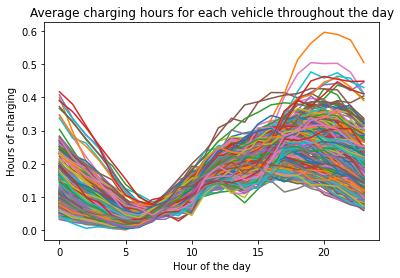

In [77]:
# plot charging over the day for each vehicle
plt.plot(vehicle_by_hour)
plt.xlabel('Hour of the day')
plt.ylabel('Hours of charging')
plt.title('Average charging hours for each vehicle throughout the day')
plt.show()

This data does not result in peaks like the previous 2 datasets, because the structure of this dataset is different. For the previous 2 datasets, activity is logged as plugin time + plugin duration. Whereas for this dataset, activity is logged as whether or not power is drawn for every 10-min chunk throughout the day, throughout the year.

In [78]:
vehicle_by_hourT = vehicle_by_hour.T.copy()
vehicle_by_hourT.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
vehicle_1,0.099087,0.072603,0.052968,0.032877,0.016438,0.003653,0.021461,0.040639,0.057534,0.092237,0.110502,0.134247,0.163927,0.193151,0.174886,0.199543,0.213699,0.205023,0.181735,0.188584,0.186301,0.174886,0.158447,0.13653
vehicle_2,0.163927,0.131507,0.106393,0.084932,0.058447,0.041553,0.043379,0.054338,0.101826,0.126484,0.144749,0.196804,0.215068,0.219635,0.221461,0.230137,0.241553,0.283562,0.280365,0.259817,0.260731,0.236530,0.235616,0.19589


<a id="kmeans"></a>
## A. K-Means Clustering

In [79]:
# let's see if these charging activities form clusters
# Let's prepare our X matrix
X = vehicle_by_hourT.copy()
ss = StandardScaler()

# fit, transform
ss.fit(X)
X_sc = ss.transform(X)

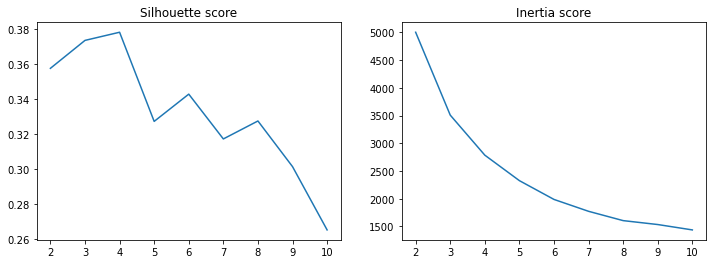

In [80]:
# plot silhouette score and inertia score
plot_silhouette(group_cluster)

Silhouette score is highest with k=4 but the elbow in the inertia score is maybe when k=3. Let's pick k=3.

In [81]:
km = KMeans(n_clusters=3, random_state=42)
km.fit(X_sc)

# attach predicted cluster to original points
vehicle_by_hourT['cluster'] = km.labels_

# mean values of each cluster
vehicle_cluster = vehicle_by_hourT.groupby(by='cluster').mean()
vehicle_cluster = vehicle_cluster.T
vehicle_cluster.head()

cluster,0,1,2
0,0.249841,0.160998,0.093936
1,0.208276,0.123741,0.069487
2,0.169514,0.094361,0.052213
3,0.137449,0.070839,0.040054
4,0.102067,0.051201,0.026681


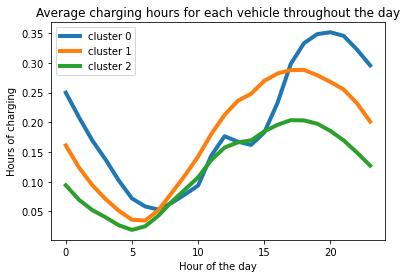

In [82]:
# plot!
for i in range(vehicle_cluster.shape[1]):
    plt.plot(vehicle_cluster.loc[:,i], label='cluster '+str(i), linewidth=4)
plt.xlabel('Hour of the day')
plt.ylabel('Hours of charging')
plt.title('Average charging hours for each vehicle throughout the day')
plt.legend()
plt.show()

All clusters have peak charging activity in the evening. The 3 clusters seem to be:
1. Peak charging at 8pm, with a smaller peak at noon
2. Peak charging at 5pm - with longer charging times
3. Peak charging at 5pm - with shorter charging times

In [83]:
vehicle_cluster.sum(axis=0)

cluster
0    4.646582
1    4.197119
2    2.873829
dtype: float64

Charging at home occurs in the evening. Charging at work peaks in the morning only on weekdays. Usage of publicly accessible charging stations peak in the morning, at lunchtime, and at dinnertime, for both weekdays and weekends.

Even if EVs become more accessible (price-wise due to the used-car market), owners still need access to charging facilities for their vehicles. Since most charging happens at home, it is important to consider housing types and distributions. Charging is easy for dwellers of single-family homes. However, for residents who live in apartments, condominiums, or who only have street parking, charging is an issue. These vehicles are called ['garage orphan EVs'](http://www.seattle.gov/Documents/Departments/OSE/FINAL%20REPORT_Removing%20Barriers%20to%20EV%20Adoption_TO%20POST.pdf).

<a id="housing_permits"></a>
# 4. Seattle housing permits
In Seattle city, Washington, 8% of the housing inventory was comprised of houses built since 2010 [source](https://www.census.gov/acs/www/data/data-tables-and-tools/narrative-profiles/2018/report.php?geotype=place&state=53&place=63000). We look at the distribution of housing in Seattle, as represented by approved housing permits from 2010 until 2021.

In [84]:
housing_orig = pd.read_csv('../Data/Residential_Building_Permits_Issued_and_Final.csv')

# conver to lower snakecase
housing_orig.columns = housing_orig.columns.str.lower()
housing_orig.rename(columns=lambda c: c.replace(' ','_'), inplace=True)

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (39,40,50) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [85]:
cols_interest = ['address','lot_size','aptype','new','demo','dweltype','year_issued','cra','comments','neighborhood','longitude','latitude']
housing = housing_orig[cols_interest]
housing = housing.dropna(subset=['lot_size','longitude','latitude'],axis=0)
housing.reset_index(inplace=True, drop=True)

In [86]:
housing.head(2)

,address,lot_size,aptype,new,demo,dweltype,year_issued,cra,comments,neighborhood,longitude,latitude
0,10023 14TH AVE NW,5000.0,Construction Permit,1,0,Detached Single-Family,2006,North Beach/Blue Ridge,"Construct new 2-story with basement Single Family Residence with attached 2-car garage, per plans",Ballard,-122.37438,47.702231
1,10023 14TH AVE NW,5000.0,Demolition Permit,0,1,Detached Single-Family,2006,North Beach/Blue Ridge,Demo existing SFR.,Ballard,-122.37438,47.702231


In [87]:
housing['aptype'].value_counts() # type of permit

Construction Permit      17550
PTS                      12395
Demolition Permit         5298
PTS PERMIT                 288
Phased Project Permit       63
Name: aptype, dtype: int64

In [88]:
# keep only 'Construction Permit' rows
housing = housing[housing['aptype']=='Construction Permit']
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17550 entries, 0 to 23408
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       17550 non-null  object 
 1   lot_size      17550 non-null  float64
 2   aptype        17550 non-null  object 
 3   new           17550 non-null  int64  
 4   demo          17550 non-null  int64  
 5   dweltype      17550 non-null  object 
 6   year_issued   17550 non-null  int64  
 7   cra           17543 non-null  object 
 8   comments      17549 non-null  object 
 9   neighborhood  17543 non-null  object 
 10  longitude     17550 non-null  float64
 11  latitude      17550 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1.7+ MB


In [89]:
housing.describe()

,lot_size,new,demo,year_issued,longitude,latitude
count,1.755000e+04,17550.000000,17550.000000,17550.000000,17550.000000,17550.000000
mean,2.095265e+04,5.964900,0.037151,2013.431396,-122.336286,47.625620
std,3.951852e+05,27.026505,1.424887,4.549529,0.039139,0.059211
min,2.830000e+02,0.000000,0.000000,1999.000000,-122.419588,47.495818
25%,4.530000e+03,1.000000,0.000000,2009.000000,-122.370697,47.570057
50%,5.700000e+03,1.000000,0.000000,2014.000000,-122.336616,47.636262
75%,7.976000e+03,2.000000,0.000000,2017.000000,-122.302340,47.674812
max,2.348970e+07,654.000000,174.000000,2021.000000,-122.238287,47.733952


In [90]:
# what are these very, very large lot sizes for?
housing[housing['lot_size']>1e7]

,address,lot_size,aptype,new,demo,dweltype,year_issued,cra,comments,neighborhood,longitude,latitude
9807,2100 NE WHITMAN LN,23489700.0,Construction Permit,1,0,Congregate Housing,2016,University District,"Phased Project: Construction of Student Housing Building (Building C) and occupy, per plan.",Northeast,-122.305018,47.660769
15160,4294 WHITMAN LN NE,23489700.0,Construction Permit,1,0,Congregate Housing,2016,University District,"Phased Project: Construction of Student Housing Building (Building D) and occupy, per plan",Northeast,-122.304022,47.660031
15167,4320 WHITMAN LN NE,23489700.0,Construction Permit,1,0,Congregate Housing,2016,University District,"Phased Project: Construction of Student Housing Building (Building B) and occupy, per plan",Northeast,-122.304560,47.660302
19118,7101 62ND AVE NE,14044051.0,Construction Permit,148,0,Apartment,2017,Laurelhurst/Sand Point,"Establish use as low income residential and construct Substantial Alterations to existing Building 9 at Magnuson Park, occupy per plan. Mechanical is included.",Northeast,-122.262855,47.680574
19579,6870 62ND AVE NE,14044051.0,Construction Permit,26,0,Multifamily Non-Ground Level Dwelling,2010,Laurelhurst/Sand Point,Establish use and construct two 3-story apartment and one community bldg per plan. North Apartment this permit. Review and process of 3 AP's under 6168222.,Northeast,-122.261716,47.678574
19770,6818 62ND AVE NE,14044051.0,Construction Permit,15,0,Apartment,2012,Laurelhurst/Sand Point,Construct new multifamily building and occupy per plan.,Northeast,-122.261304,47.678283
19870,6800 62ND AVE NE,14044051.0,Construction Permit,26,0,Multifamily Non-Ground Level Dwelling,2010,Laurelhurst/Sand Point,Construct 3-story apartment per plan. South Apartment this permit. Review and process of 3 AP's under 6168222.,Northeast,-122.261660,47.677897
20030,6951 62ND AVE NE,14044051.0,Construction Permit,39,0,Apartment,2012,Laurelhurst/Sand Point,Construct new multifamily apartment building and occupy per plans.,Northeast,-122.262886,47.678969


It seems to be 1 lot size to cover multiple types of housing types.

<a id="benford"></a>
## A. Benford's Law?

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


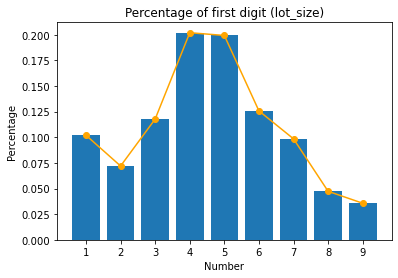

In [91]:
# Does the new construction lot_size follow Benford's Law?

housing['FIRST_DIGIT']= housing['lot_size'].astype(int).astype(str).str[0]

# get the % of FIRST_DIGIT
digit_percentages = housing['FIRST_DIGIT'].value_counts(normalize=True).sort_index()
digits = digit_percentages.index

# Plot!
plt.bar(digits,digit_percentages)
plt.plot(digit_percentages, color='orange', marker='o')
plt.xlabel('Number')
plt.ylabel('Percentage')
plt.title('Percentage of first digit (lot_size)')
plt.show()

The lot sizes DO NOT follow Benford's Law.

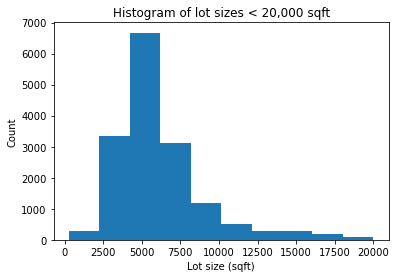

In [92]:
# histogram of lot sizes < 20000sqft
housing_norm = housing[housing['lot_size']<20_000]
plt.hist(housing_norm['lot_size'])
plt.title('Histogram of lot sizes < 20,000 sqft')
plt.xlabel('Lot size (sqft)')
plt.ylabel('Count')
plt.show()

In [93]:
housing['dweltype'].value_counts(dropna=False)

Detached Single-Family                      8257
Multifamily Ground Level Townhouse          1882
Townhouse                                   1735
Accessory Dwelling, Attached                1326
Apartment                                   1258
Accessory Dwelling, Detached                1034
Rowhouse                                     815
Multifamily Non-Ground Level Dwelling        412
Accessory Live/Work                          326
Small Efficiency Dwelling                    133
Multifamily Ground Level Apartment           119
Congregate Housing                            72
None                                          64
Multifamily Other                             38
Accessory Caretaker                           31
Cottage                                       16
Assisted Living                               15
Multifamily Ground Level Tandem Dwelling       7
No Dwelling Units                              6
Carriage House                                 3
Not Reviewed        

Inspect and deal with duplicate lot sizes.

In [94]:
housing[housing.duplicated('lot_size')].sort_values(by='lot_size',ascending=False).head(5)

,address,lot_size,aptype,new,demo,dweltype,year_issued,cra,comments,neighborhood,longitude,latitude,FIRST_DIGIT
15160,4294 WHITMAN LN NE,23489700.0,Construction Permit,1,0,Congregate Housing,2016,University District,"Phased Project: Construction of Student Housing Building (Building D) and occupy, per plan",Northeast,-122.304022,47.660031,2
15167,4320 WHITMAN LN NE,23489700.0,Construction Permit,1,0,Congregate Housing,2016,University District,"Phased Project: Construction of Student Housing Building (Building B) and occupy, per plan",Northeast,-122.304560,47.660302,2
19579,6870 62ND AVE NE,14044051.0,Construction Permit,26,0,Multifamily Non-Ground Level Dwelling,2010,Laurelhurst/Sand Point,Establish use and construct two 3-story apartment and one community bldg per plan. North Apartment this permit. Review and process of 3 AP's under 6168222.,Northeast,-122.261716,47.678574,1
20030,6951 62ND AVE NE,14044051.0,Construction Permit,39,0,Apartment,2012,Laurelhurst/Sand Point,Construct new multifamily apartment building and occupy per plans.,Northeast,-122.262886,47.678969,1
19870,6800 62ND AVE NE,14044051.0,Construction Permit,26,0,Multifamily Non-Ground Level Dwelling,2010,Laurelhurst/Sand Point,Construct 3-story apartment per plan. South Apartment this permit. Review and process of 3 AP's under 6168222.,Northeast,-122.261660,47.677897,1


In [95]:
# campus housing is listed as covering the entire campus area. Remove it
housing.drop(index=[15160, 15167],inplace=True)

# multiple housing projects on 62nd Ave, all of them apartments/multifamily dwellings. Only keep 1 row
housing.drop(index=[19579, 19770, 19870],inplace=True)

# multiple housing projects on Boren Ave, all of them townhouses. Only keep 1 row
housing.drop(index=[6055,6825],inplace=True)

# remove Seward Park listing - construction alteration to all dwelling types at that location
housing.drop(housing[housing['lot_size']==689260.0].index, inplace=True)
# df.drop(df[df.score < 50].index, inplace=True)

# drop 1 rows with null in 'comments'
housing.dropna(subset=['comments'],inplace=True)

# pd.set_option('display.max_colwidth', None)
housing_new = housing[housing['comments'].str.contains('Construct new')].copy()

housing_new.reset_index(inplace=True,drop=True)

housing_new.head(2)

,address,lot_size,aptype,new,demo,dweltype,year_issued,cra,comments,neighborhood,longitude,latitude,FIRST_DIGIT
0,10023 14TH AVE NW,5000.0,Construction Permit,1,0,Detached Single-Family,2006,North Beach/Blue Ridge,"Construct new 2-story with basement Single Family Residence with attached 2-car garage, per plans",Ballard,-122.374380,47.702231,5
1,10702 14TH AVE NE,8704.0,Construction Permit,1,0,"Accessory Dwelling, Detached",2015,Northgate/Maple Leaf,"Construct new DADU accessory to single family dwelling, in east back yard, per plans.",North,-122.313476,47.706889,8
2,106 30TH AVE,4020.0,Construction Permit,1,0,Detached Single-Family,2009,Central Area/Squire Park,"Construct new single family residence on north portion of lot, per plan.",Central,-122.293535,47.601962,4
3,10036 ASHWORTH AVE N,6449.0,Construction Permit,1,0,Detached Single-Family,2007,Licton Springs,Establish use as single family residence. Construct new one family dwelling with attached garage. Per plan. (MUP #3004193),Northwest,-122.338935,47.702455,6
4,10050 40TH AVE SW,5322.0,Construction Permit,1,0,Detached Single-Family,2015,Arbor Heights,"Construct new single family residence with detached garage, per plan.",Southwest,-122.382809,47.512308,5


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


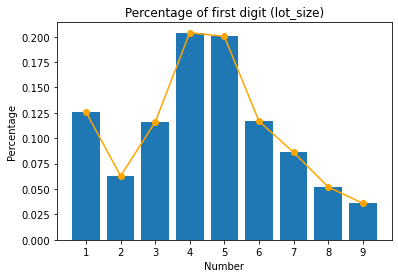

In [96]:
# Does the new construction lot_size follow Benford's Law?

# get the % of FIRST_DIGIT
digit_percentages = housing_new['FIRST_DIGIT'].value_counts(normalize=True).sort_index()
digits = digit_percentages.index

# Plot!
plt.bar(digits,digit_percentages)
plt.plot(digit_percentages, color='orange', marker='o')
plt.xlabel('Number')
plt.ylabel('Percentage')
plt.title('Percentage of first digit (lot_size)')
plt.show()

Not this subset either.

In [97]:
housing_new['dweltype'].value_counts()

Detached Single-Family                      568
Townhouse                                   132
Accessory Dwelling, Detached                124
Multifamily Ground Level Townhouse           92
Apartment                                    72
Accessory Dwelling, Attached                 29
Rowhouse                                     28
Small Efficiency Dwelling                    26
Accessory Live/Work                          17
Multifamily Non-Ground Level Dwelling        14
Cottage                                       3
None                                          3
Multifamily Other                             2
Accessory Caretaker                           1
Multifamily Ground Level Tandem Dwelling      1
Multifamily Ground Level Apartment            1
Name: dweltype, dtype: int64

In [98]:
housing_new['single_fam'] = housing_new['dweltype'].map(lambda x: 1 if x=='Detached Single-Family' else 0)

<a id="single_family"></a>
## B. Single-family housing

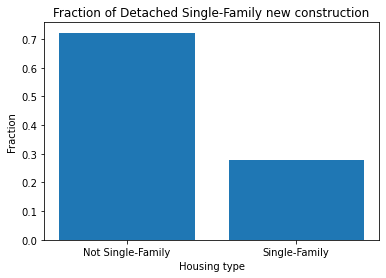

In [99]:
# fraction single family
single_fam = housing_new.groupby('single_fam')['lot_size'].sum()/housing_new['lot_size'].sum()
plt.bar(x=single_fam.index, height=single_fam)
plt.title('Fraction of Detached Single-Family new construction')
plt.xticks([0,1], ['Not Single-Family','Single-Family'])
plt.ylabel('Fraction')
plt.xlabel('Housing type')
plt.show()

In [100]:
single_fam

single_fam
0    0.722559
1    0.277441
Name: lot_size, dtype: float64

It's good that more non-single-family type homes are being constructed, as these tend to be cheaper. But these homes also typically do not have easy access to power for the parked EV. Thought and effort need to be given to expanded and equitable access to vehicle charging across economic demographics.